# Forecasting Temperature in Seattle, Washington

Rachael An and Aleksandra Kogalovski

# Executive Summary

The purpose of this analysis is to determine which of four statistical forecasting methods will produce the most accurate prediction for daily temperature patterns in Seattle, Washington. We compared four different forecasting methods: an **AR(2)** model (an autoregressive model where the current value is based on the previous two values), a **Seasonal Naïve forecast** (a method where each forecast is set to be equal to the last observed value from the same season), **Holt-Winters’ forecast with additive seasonality** (an extension of Holt's exponential smoothing method that captures seasonality), and a **SARIMAX model** (a seasonal autoregressive integrated moving average with exogenous factors). 

Each model was initially trained on ten years of maximum daily temperature data (2003-2012) and assessed based on prediction accuracy with five years of test data (2013-2017). The best model, selected based on this assessment, would be used to generate a forecast into the future.

When examining the diagnostic and residual plots, we determined that the SARIMAX model provided the best fit, with the Holt-Winters' forecast with additive seasonality and AR(2) coming in a very close second and third place, and the seasonal naïve forecast coming in last. Based on this analysis, we opted to leverage the SARIMAX model to build our forecast into the future. Overall, the top three models provided excellent forecasts, with the seasonal naïve forecast being good but having the most room for improvement. 

Once we calculated the Root Mean Squared Error for each model, we found that the Holt-Winters' forecast with additive seasonality actually provided the best fit with an RMSE of just 2.58˚F. The AR(2) model was second with an RMSE of 3.21˚F, and the SARIMAX model came in a close third at 3.90˚F. The seasonal naïve forecast still had the most room for improvement with an RMSE of 4.49˚F. To confirm our findings, we performed an AIC analysis for each model, finding that the AIC values somewhat aligned with our RMSE assessments. The Holt-Winters' forecast yielded the lowest AIC at 348.1, indicating a favorable fit. In contrast to the RMSE results, the seasonal naïve model had the second-lowest AIC at 362.54. The SARIMAX model once again came in third at 531.31, while the AR(2) model exhibited the highest AIC value by far at 846.43.

# Introduction

The [Did it rain in Seattle?](https://www.kaggle.com/datasets/rtatman/did-it-rain-in-seattle-19482017/) dataset contains complete records of daily rainfall and temperature patterns from January 1st, 1948 to December 12, 2017. This data was collected at the Seattle-Tacoma International Airport and was compiled by the National Oceanic and Atmospheric Administration (NOAA).

This dataset is comprised of five columns:
- DATE = The date of the observation
- PRCP = The amount of precipitation, in inches
- TMAX = The maximum temperature for that day, in degrees Fahrenheit
- TMIN = The minimum temperature for that day, in degrees Fahrenheit
- RAIN = TRUE if rain was observed on that day, FALSE if it was not

In this report, we test multiple forecasting methods to determine which provides the most accurate prediction of maximum daily temperature in Seattle, Washington. Each of the four model evaluated is initially trained on ten years of maximum daily temperature data (2003-2012) and assessed based on prediction accuracy with five years of test data (2013-2017). The best model, selected based on this assessment, would be selected to generate a forecast into the future. The original dataset contains daily data, but for the purposes of our analysis, we resampled the data to be monthly instead.

# Exploratory Data Analysis 

In [22]:
import pandas as pd
from pandas.plotting import lag_plot

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pmdarima as pm
import warnings

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error
from dateutil.relativedelta import relativedelta

In [23]:
# read csv
seaweather_raw = pd.read_csv(r'seaweather.csv', parse_dates = ['DATE'], index_col = 'DATE')

# view data
print(seaweather_raw.head())
print("\n")
print(seaweather_raw.tail())

            PRCP  TMAX  TMIN  RAIN
DATE                              
1948-01-01  0.47    51    42  True
1948-01-02  0.59    45    36  True
1948-01-03  0.42    45    35  True
1948-01-04  0.31    45    34  True
1948-01-05  0.17    45    32  True


            PRCP  TMAX  TMIN   RAIN
DATE                               
2017-12-10   0.0    49    34  False
2017-12-11   0.0    49    29  False
2017-12-12   0.0    46    32  False
2017-12-13   0.0    48    34  False
2017-12-14   0.0    50    36  False


In [24]:
# filter data between 2003 and 2017
seaweather_15yr = seaweather_raw['2003-01-01':'2017-12-31']

# resample the data to monthly instead of daily
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    seaweather_15yr = seaweather_15yr.resample('M').mean()

# print the filtered and resampled data
print(seaweather_15yr.head())
print("\n")
print(seaweather_15yr.tail())

                PRCP       TMAX       TMIN
DATE                                      
2003-01-31  0.270645  51.096774  40.354839
2003-02-28  0.062857  47.464286  35.750000
2003-03-31  0.204516  52.419355  41.161290
2003-04-30  0.091333  55.300000  42.466667
2003-05-31  0.037419  62.870968  46.677419


                PRCP       TMAX       TMIN
DATE                                      
2017-08-31  0.000645  81.516129  59.000000
2017-09-30  0.019667  73.800000  55.566667
2017-10-31  0.154839  61.096774  45.290323
2017-11-30  0.287667  51.333333  42.000000
2017-12-31  0.079286  47.214286  34.142857


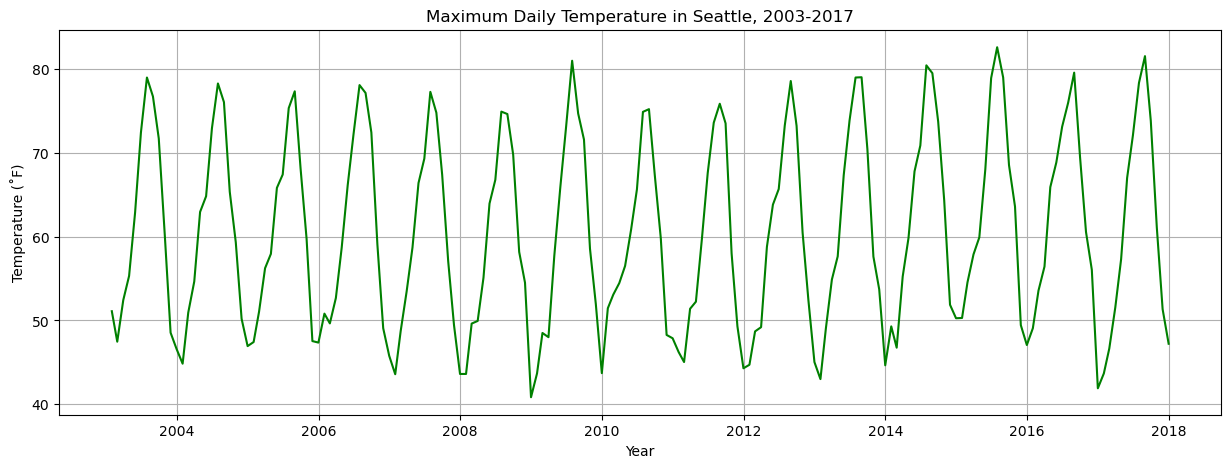

In [25]:
# set figure size for plot
plt.figure(figsize=(15, 5))

# plot maximum daily temperature over time
plt.plot(seaweather_15yr.index, seaweather_15yr['TMAX'], label='Maximum Temperature', color='green')

# set plot attributes
plt.title('Maximum Daily Temperature in Seattle, 2003-2017')

plt.xlabel('Year')
plt.ylabel('Temperature (˚F)')
plt.grid(True)

plt.show()

In the time series of maximum daily temperature in Seattle over the 15-year period between 2003 and 2017, no strong trend is apparent. However there is a very strong seasonal pattern, with relatively low variability. In the summer months, the temperature tends to peak between 75˚F and 85˚F, while in the winter months, the lowest maximum daily temperature ranges between 40˚F and 50˚F. In this visualization of the data, there are no clear anomalies or outliers.

The dataset was filtered from nearly 70 years of data to 15 years to simplify the complexity of working with such a large dataset. There may be additional trends or irregularities that might only be apparent within the greater time series.

### Seasonal Decomposition

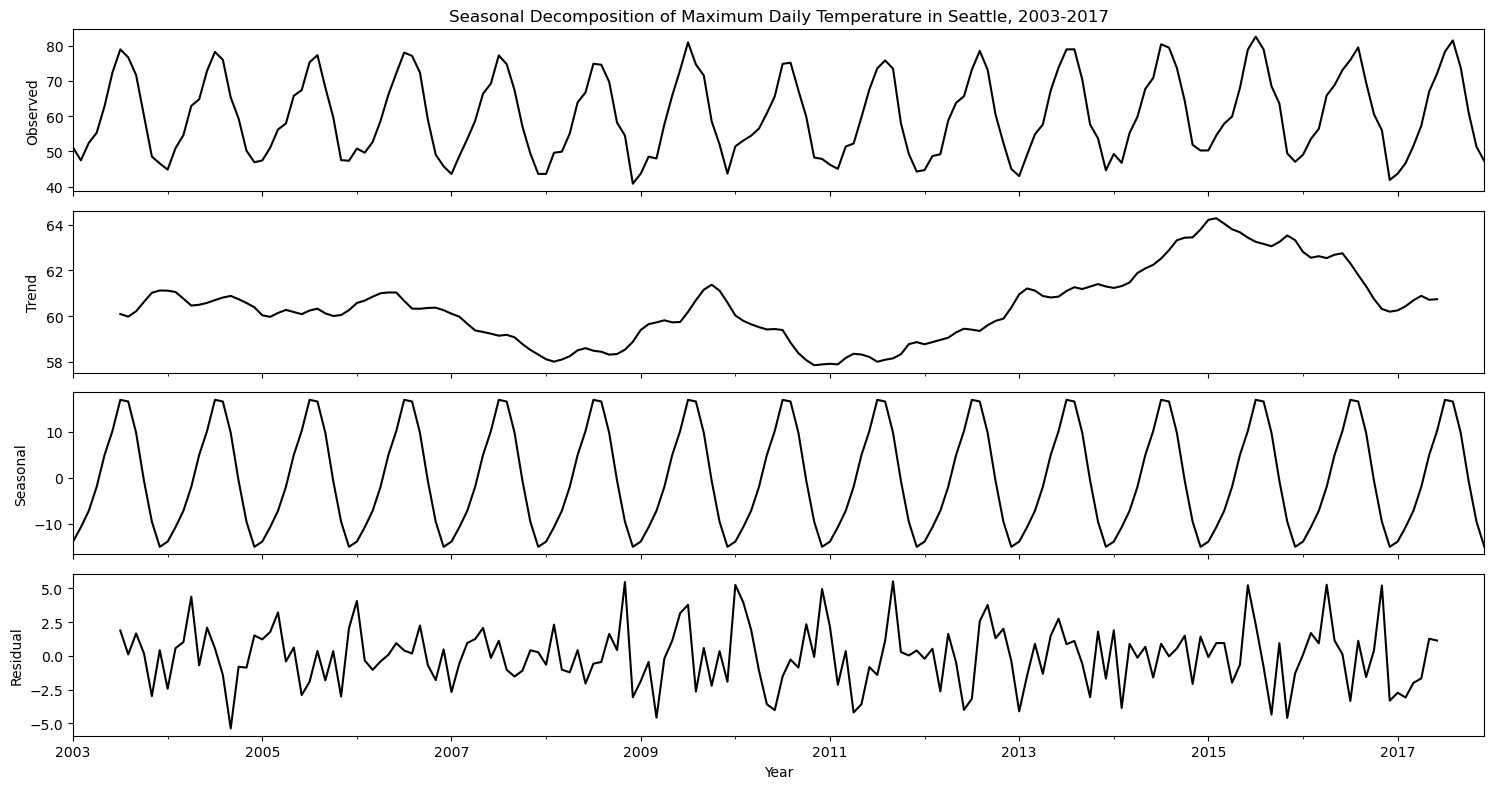

In [26]:
# seasonal decomposition
result = seasonal_decompose(seaweather_15yr['TMAX'], model='additive')

# plot decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15, 8), sharex=True)
result.observed.plot(ax=ax1, color = 'black', title='Seasonal Decomposition of Maximum Daily Temperature in Seattle, 2003-2017')
ax1.set_ylabel('Observed')

result.trend.plot(ax=ax2, color = 'black')
ax2.set_ylabel('Trend')

result.seasonal.plot(ax=ax3, color = 'black')
ax3.set_ylabel('Seasonal')

result.resid.plot(ax=ax4, color = 'black')
ax4.set_ylabel('Residual')
ax4.set_xlabel('Year')

plt.tight_layout()
plt.show()

In [27]:
# slope of trend line
trend = result.trend.dropna()
X = sm.add_constant(np.arange(len(trend)))
model = sm.OLS(trend, X).fit()
slope = model.params[1] * 26
print(f'Approximate temperature change per year: {slope:.2f}˚F/year')

# range in seasonal variation
seasonal_component = result.seasonal.dropna()
range_seasonal_variation = (seasonal_component.max() - seasonal_component.min())
print(f'Approximate range in seasonal variation: {range_seasonal_variation: .2f}˚F')

Approximate temperature change per year: 0.36˚F/year
Approximate range in seasonal variation:  31.97˚F


The seasonal decomposition of maximum daily tempurature is done using an additive model. There appears to be a very slight positive trend within the data, with an approximate temperature increase of 0.36˚F per year. The magnitude of the trend only spans approximately 6˚F in magnitude. There is a very strong seasonality in this time series, visible clearly in the seasonal component with the temperature peaking during the summer months and dropping during the winter months. Compared to the overall trend, the magnitude of the seasonal component is overwhelming, at approximately 25˚F. There is no trend or cyclicity visible in the residuals, so it doesn't appear that there are any irregular patterns in this data. Overall, Seattle weather tends to be on the mild side, with an approximate range in seasonal variation of just 31.97˚F.

# Forecasting and Modeling

### AR(2) Model
An autoregressive model where the current value is based on the previous two values

In [28]:
# fit an AR(2) model to the data
mod = SARIMAX(seaweather_15yr['TMAX'], order=(2, 0, 0), seasonal_order = (2,1,0,12))
res = mod.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35186D+00    |proj g|=  7.86735D-02

At iterate    5    f=  2.32341D+00    |proj g|=  1.11591D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   1.134D-05   2.323D+00
  F =   2.3234122171230656     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


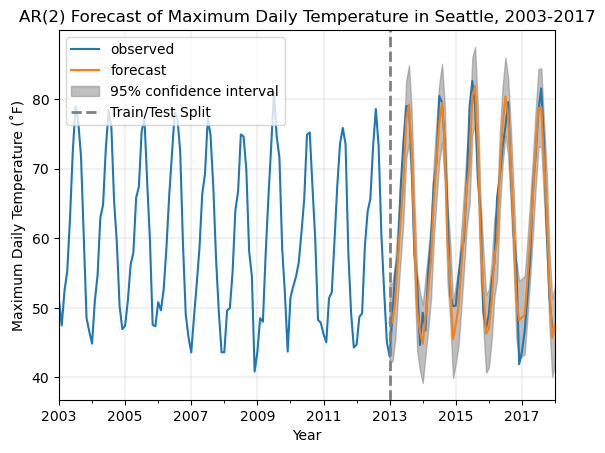

In [29]:
# plot the data and the forecast
fig, ax = plt.subplots()
seaweather_15yr['TMAX'].plot(ax=ax, label='observed')
plot_predict(res, start=120, end=180, ax=ax)

# set plot attributes
plt.xlabel('Year')
plt.ylabel('Maximum Daily Temperature (˚F)')
plt.title('AR(2) Forecast of Maximum Daily Temperature in Seattle, 2003-2017')
plt.grid(linewidth=0.25)

ax.axvline(x=seaweather_15yr.index[120], color='gray', linestyle='--', linewidth=2, label='Train/Test Split')

ax.legend()

plt.show()

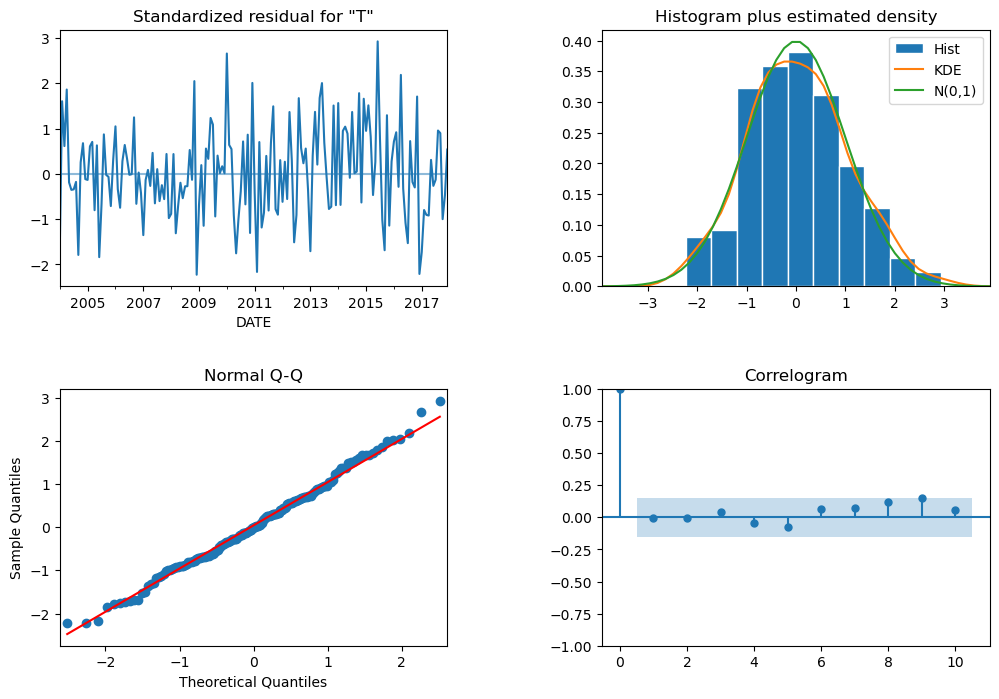

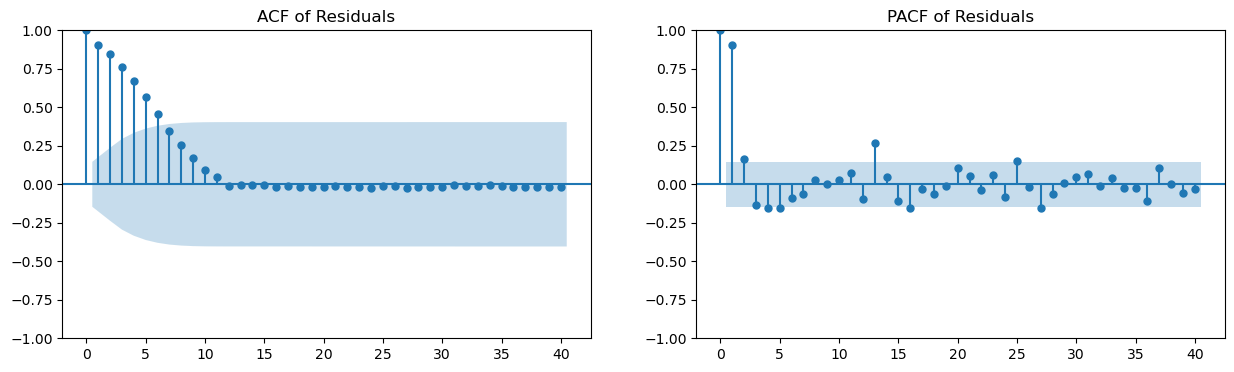

In [30]:
# plot diagnostics
res.plot_diagnostics(figsize=(12, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# ACF
plot_acf(res.resid, lags=40, ax=ax[0])
ax[0].set_title('ACF of Residuals')

# PACF
plot_pacf(res.resid, lags=40, ax=ax[1])
ax[1].set_title('PACF of Residuals')

plt.show()

In [31]:
# get the forecast values for the training period (assuming this is the intention based on the length of seaweather_15yr)
forecast_values = res.get_forecast(steps=len(seaweather_15yr))

# extract the mean forecast values
mean_forecast = forecast_values.predicted_mean

# calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(seaweather_15yr['TMAX'], mean_forecast)
print(f'Mean Absolute Error (MAE): {mae:.2f}˚F')

# calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(seaweather_15yr['TMAX'], mean_forecast))
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}˚F')

aic_ar_2 = res.aic
print(f'AIC: {aic_ar_2:.2f}')

Mean Absolute Error (MAE): 2.65˚F
Root Mean Squared Error (RMSE): 3.21˚F
AIC: 846.43


This AR(2) model is created using a train/test split where the model was trained on ten years of maximum daily temperature data (2003-2012) and assessed based on prediction accuracy with five years of test data (2013-2017). Since we are evaluating the model's effectiveness using a train/test split, we did not plot fitted values for the training portion of the observed values. An AR(2) model is justified for this data as it captures the temporal dependencies in the time series. The inclusion of lag terms beyond the first-order allows the model to better represent the underlying patterns and autocorrelations present in the temperature fluctuations over time, providing a more accurate reflection of the seasonal nature of this data.

Overall, the AR(2) model provides an excellent forecast of the maximum daily temperature in Seattle between 2013 and 2017. The plot of standardized residuals over time does not appear to show any patterns or trends that may indicate a lack of fit. In the histogram of the residuals, it appears that the residuals are approximately normally distributed. Deviations from normality might indicate issues with the model assumptions, but that does not seem to be the case with this time series. The Q-Q plot compares the distribution of residuals against a theoretical normal distribution. The adherence of the residuals to a straight line supports the conclusion that the residuals are normally distributed. 

Most of spikes in the correlogram, autocorrelation function (ACF) plot, and partial autocorrelation function (PACF) plot fall within the confidence interval, and there are no patterns between statistically significant autocorrelation spikes. In all three plots, the autocorrelation decreases very quickly as lag increases. A rapid decay suggests a quick loss of correlation between values at different lags, while slow decay may indicate persistence in the time series.

### Seasonal Naïve Forecast
A method where each forecast is set to be equal to the last observed value from the same season

In [32]:
# create training set from 2003 to 2012
train_weather = seaweather_15yr.loc[('2003-01-01' <= seaweather_15yr.index) & (seaweather_15yr.index <= '2012-12-31')]

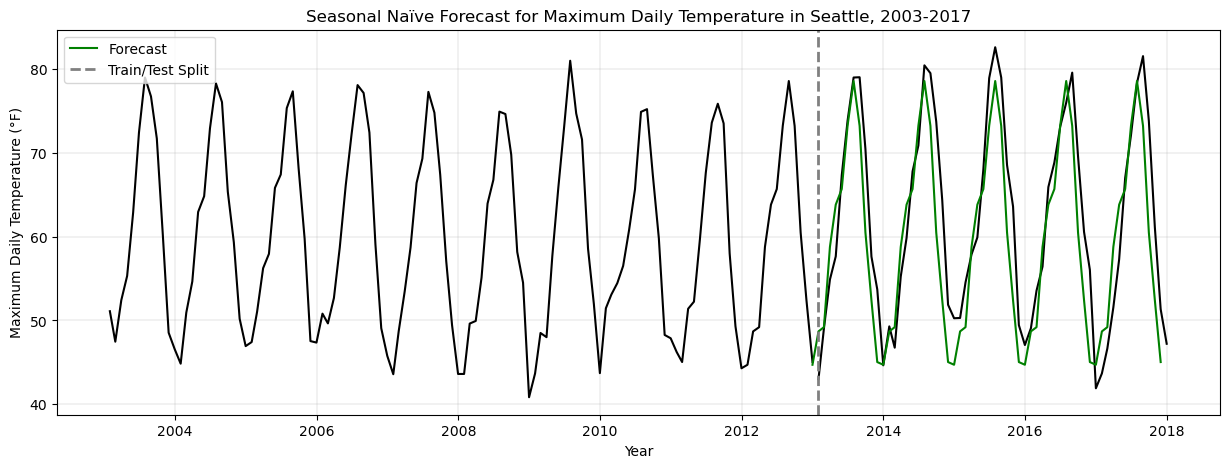

In [33]:
# seasonal naïve method
tmax_fit_snaive = train_weather['TMAX'].diff(12).mean()

# generate forecasts for 2013 to 2017
h_weather = len(seaweather_15yr.loc['2013-01-01':])
tmax_fc_snaive = [train_weather['TMAX'].iloc[-12 + (i % 12)] 
                  for i in range(len(train_weather), len(train_weather) + h_weather)]

# set figure size
plt.figure(figsize=(15, 5))

# plot training set actuals
plt.plot(train_weather.index, train_weather['TMAX'], color='black')

# plot testing set actuals
plt.plot(seaweather_15yr.loc['2013-01-01':].index, seaweather_15yr.loc['2013-01-01':, 'TMAX'], color='black')

# plot forecasts
plt.plot(pd.date_range(start=train_weather.index[-1], periods=h_weather, freq='M'), tmax_fc_snaive, label='Forecast', color='green')

# set plot attributes
plt.xlabel('Year')
plt.ylabel('Maximum Daily Temperature (°F)')
plt.title('Seasonal Naïve Forecast for Maximum Daily Temperature in Seattle, 2003-2017')
plt.grid(linewidth=0.25)

plt.axvline(x=seaweather_15yr.index[120], color='gray', linestyle='--', linewidth=2, label='Train/Test Split')
plt.legend()

plt.show()

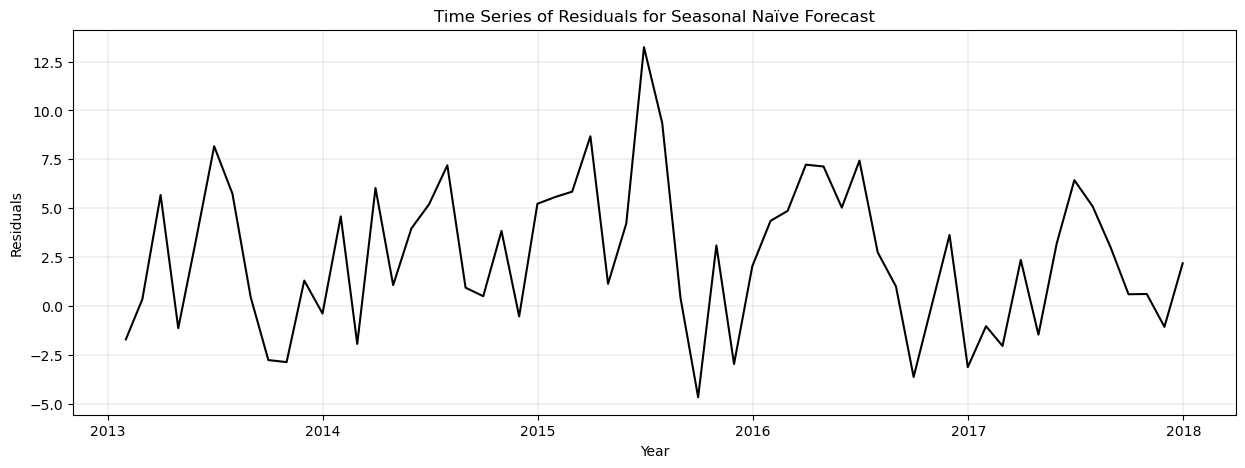

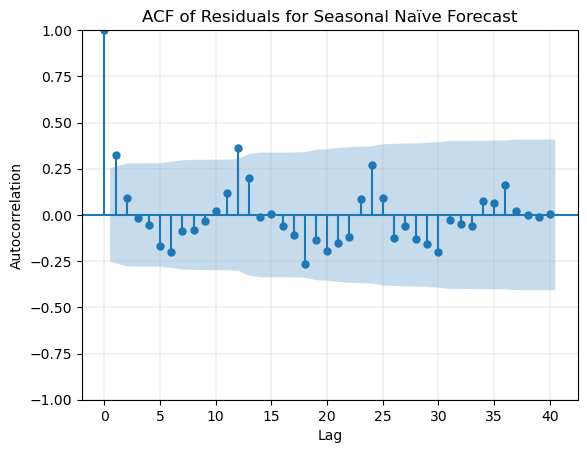

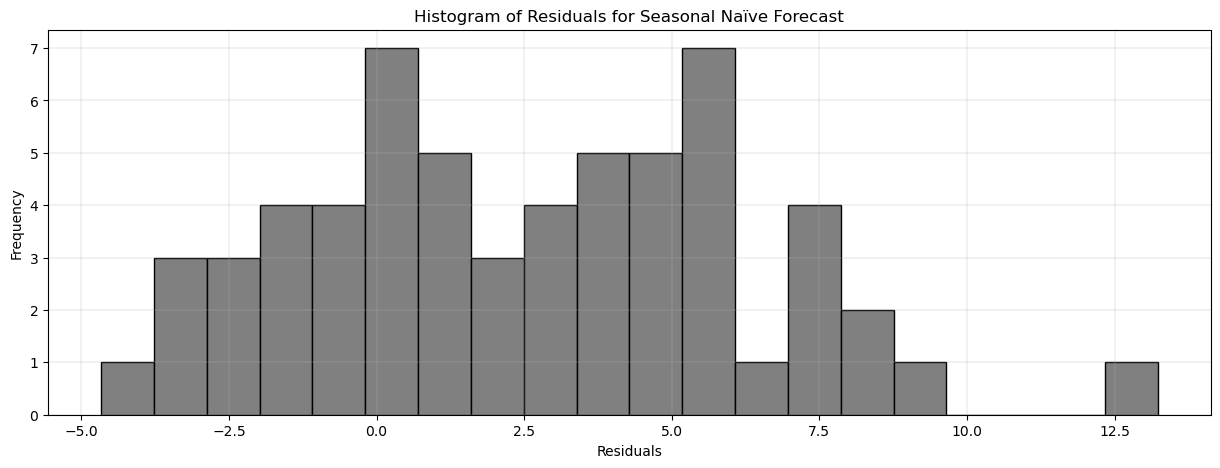

In [34]:
# calculate residuals
residuals_snaive = seaweather_15yr.loc['2013-01-01':, 'TMAX'] - tmax_fc_snaive

# plot time series of residuals
plt.figure(figsize=(15, 5))
plt.plot(seaweather_15yr.loc['2013-01-01':].index, residuals_snaive, color='black')
plt.title('Time Series of Residuals for Seasonal Naïve Forecast')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.grid(linewidth=0.25)
plt.show()

# ACF of residuals
plot_acf(residuals_snaive, lags=40)
plt.title('ACF of Residuals for Seasonal Naïve Forecast')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(linewidth=0.25)
plt.show()

# histogram of residuals
plt.figure(figsize=(15, 5))
plt.hist(residuals_snaive, bins=20, color='gray', edgecolor='black')
plt.title('Histogram of Residuals for Seasonal Naïve Forecast')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(linewidth=0.25)
plt.show()

In [35]:
# actual values for the test period
actual_values = seaweather_15yr.loc['2013-01-01':, 'TMAX']

# calculate the mean squared error (MSE)
mse_snaive = np.mean(residuals_snaive**2)

# calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, tmax_fc_snaive)
print(f'Mean Absolute Error (MAE): {mae:.2f}°F')

# calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(actual_values, tmax_fc_snaive))
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}°F')

# number of parameters in the model
num_params_snaive = 1

# calculate AIC
aic_snaive = len(train_weather) * np.log(mse_snaive) + 2 * num_params_snaive
print(f"AIC: {round(aic_snaive, 2)}")

Mean Absolute Error (MAE): 3.59°F
Root Mean Squared Error (RMSE): 4.49°F
AIC: 362.54


This Seasonal Naïve model is created using a train/test split where the model was trained on ten years of maximum daily temperature data (2003-2012) and assessed based on prediction accuracy with five years of test data (2013-2017). A Seasonal Naïve model is justified for this data as it leverages the inherent seasonality in the temperature patterns, making it an effective baseline method.

Visually, the seasonal naïve forecast appears to be a good prediction of the maximum daily temperature, as the predicted values adhere very closely to the observed values. The time series of the residuals appears to have a very slight positive trend, indicating that there might be a small but consistent inaccuracy in the forecast. The ACF of residuals has only one statistically significant autocorrelation spike that falls outside of the confidence interval, however there is some slight periodicity among the spikes that could indicate that the seasonal component isn't fully being captured by the differencing. The histogram of residuals follows a vaguely normal distribution, but there a slight right skew and some bimodality. Both the mean absolute error (MAE) and root mean squared error (RMSE) are relatively low, with the former being only 3.59°F and the latter being less than a degree more at 4.49°F. Overall, the diagnostics indicate that the seasonal naïve forecast is okay, but there is room for improvement. 

### Holt-Winters’ Forecast with Additive Seasonality
An extension of Holt's exponential smoothing method that captures seasonality

In [36]:
test_weather = seaweather_15yr.loc[(seaweather_15yr.index >= '2013-01-01') & (seaweather_15yr.index <= '2017-12-14')]

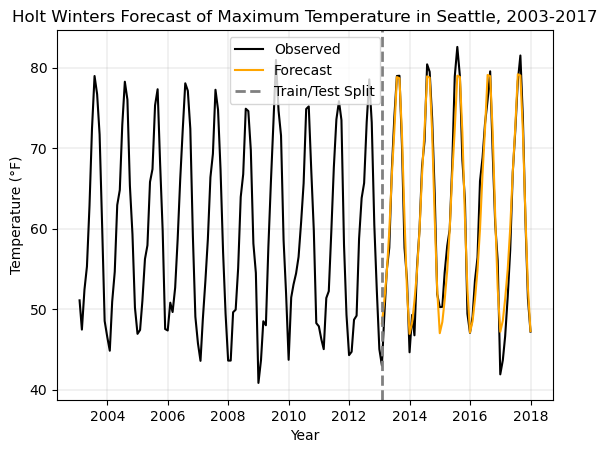

In [37]:
# create an additive Holt-Winters model instance and fit the model to the data
model_add = ExponentialSmoothing(seaweather_15yr['TMAX'], trend='add', seasonal='add', seasonal_periods=12)
result_add = model_add.fit()

# create forecast
forecast_steps = len(test_weather) + 1
forecast = result_add.forecast(steps=forecast_steps)

# set date range for the forecast
start_date = '2013-01-01'
forecast_index = pd.date_range(start=start_date, periods=forecast_steps, freq='M')
forecast.index = forecast_index

# plot observed and forecasted values
fig, ax = plt.subplots()
ax.plot(seaweather_15yr.index, seaweather_15yr['TMAX'], color='black', label='Observed')
ax.plot(forecast.index, forecast, color='orange', label='Forecast')

# set plot attributes
plt.legend()
plt.xlabel('Year')
plt.ylabel('Temperature (°F)')
plt.title('Holt Winters Forecast of Maximum Temperature in Seattle, 2003-2017')
plt.grid(linewidth=0.25)

plt.axvline(x=seaweather_15yr.index[120], color='gray', linestyle='--', linewidth=2, label='Train/Test Split')
plt.legend()

plt.show()

This exponential smoothing model is created using a train/test split where the model was trained on ten years of maximum daily temperature data (2003-2012) and assessed based on prediction accuracy with five years of test data (2013-2017).

It is the most appropriate to create an additive version of this model since the magnitude of the seasonality is not related to the magnitude of the data. The forecast matches the yearly seasonal patterns in the data perfectly, as there are peaks and troughs every 1 year. However, the level of these peaks and troughs are pretty constant. Those reach its highs and lows around the same temperature level every year, which is slightly inconsistent with how the observed values are graphed as. As seen in the observed values, there is a slight trend that goes up and then down at both the highs and lows. However, since this forecast captures the yearly seasonal patterns perfectly, it is safe to conclude that this forecast somewhat accurately predicts the observed values in the test data.

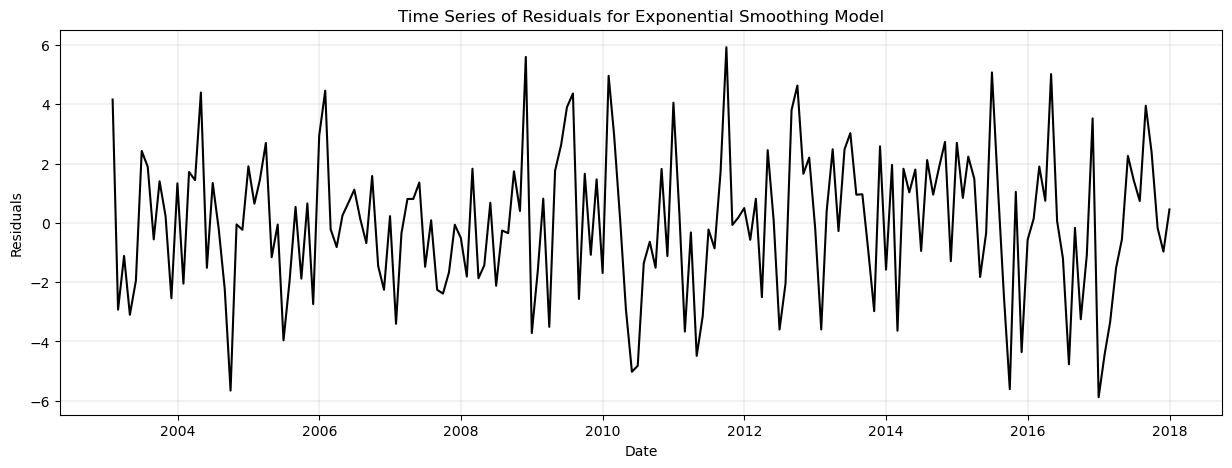

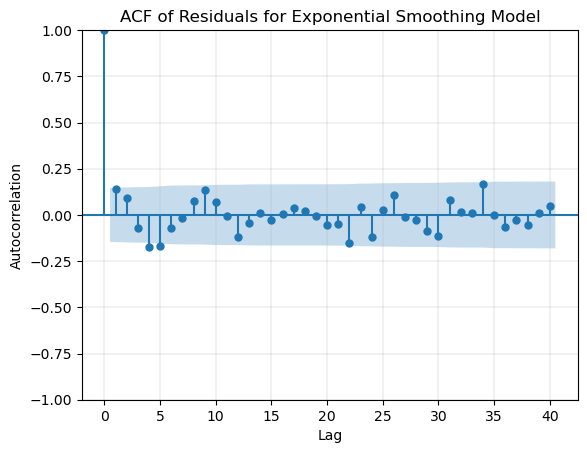

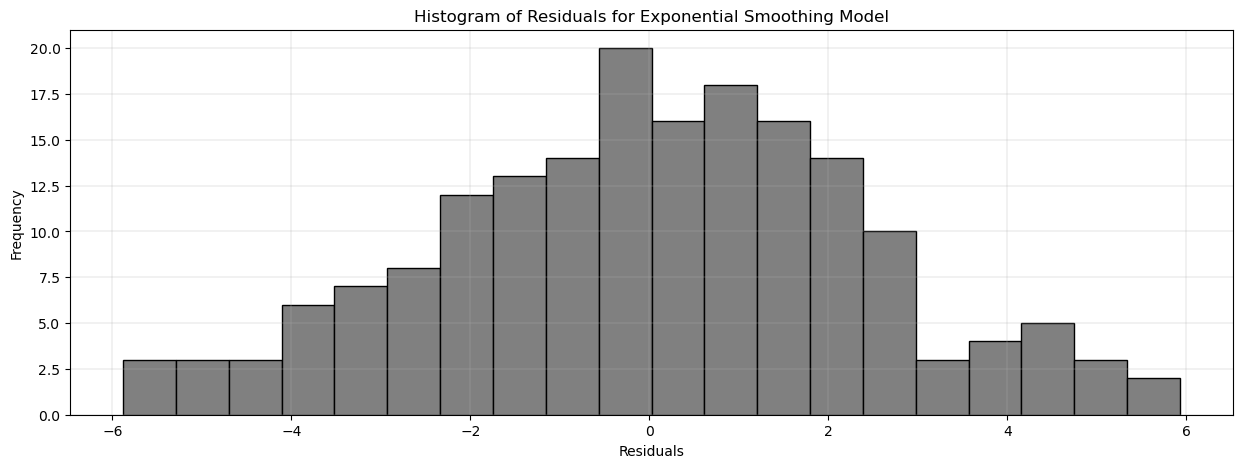

In [38]:
# time series of residuals
plt.figure(figsize=(15, 5))
plt.plot(result_add.resid.index, result_add.resid, color='black')
plt.title('Time Series of Residuals for Exponential Smoothing Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(linewidth=0.25)
plt.show()

# ACF of residuals
plot_acf(result_add.resid, lags=40)
plt.title('ACF of Residuals for Exponential Smoothing Model')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(linewidth=0.25)
plt.show()

# histogram of residuals
plt.figure(figsize=(15, 5))
plt.hist(result_add.resid, bins=20, color='gray', edgecolor='black')
plt.title('Histogram of Residuals for Exponential Smoothing Model')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(linewidth=0.25)
plt.show()

Analyzing these plots will broaden our understanding of how accurately the forecast captures the data in the test data. There is not a pattern in the residuals, as there is constant variance, randomness, and is centered at 0. There is also not clear observed trends or cycles in the plot. In the autocorrelation plot, there are just lags at 4 and 5 that extend beyond the error bands. Overall, there is not a substantial amount of significant autocorrelation, which suggests a relatively accurate forecast. Additionally, the histogram of residuals looks like a normal distribution. However, there is substantially more data around the area greater than 0, which is enough significant data to consider this plot to be slightly left skewed. Consistent with the analysis above, it is clear to me that the Holt-Winters forecast with additive seasonality predicts the observed data pretty accurately, despite a few significant points in the histogram and autocorrelation plot.

In [39]:
# actual values for the test period
actual_values = seaweather_15yr.loc['2013-01-01':, 'TMAX']

# calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, forecast)
print(f'Mean Absolute Error (MAE): {mae:.2f}°F')

# calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(actual_values, forecast))
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}°F')

aic_exponential_smoothing = result_add.aic
print(f'AIC: {aic_exponential_smoothing:.2f}')

Mean Absolute Error (MAE): 2.01°F
Root Mean Squared Error (RMSE): 2.58°F
AIC: 348.01


### SARIMAX
A seasonal autoregressive integrated moving average with exogenous factors

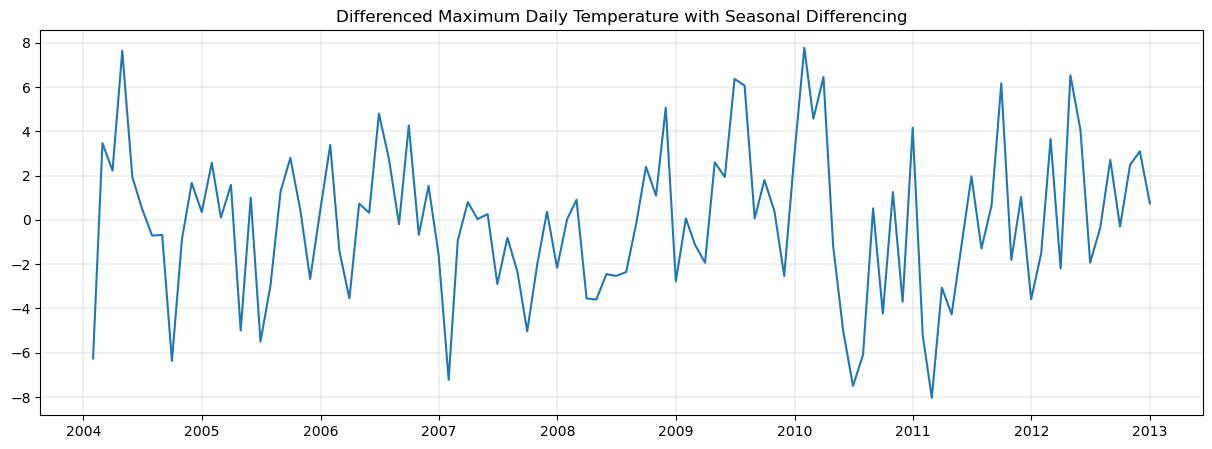

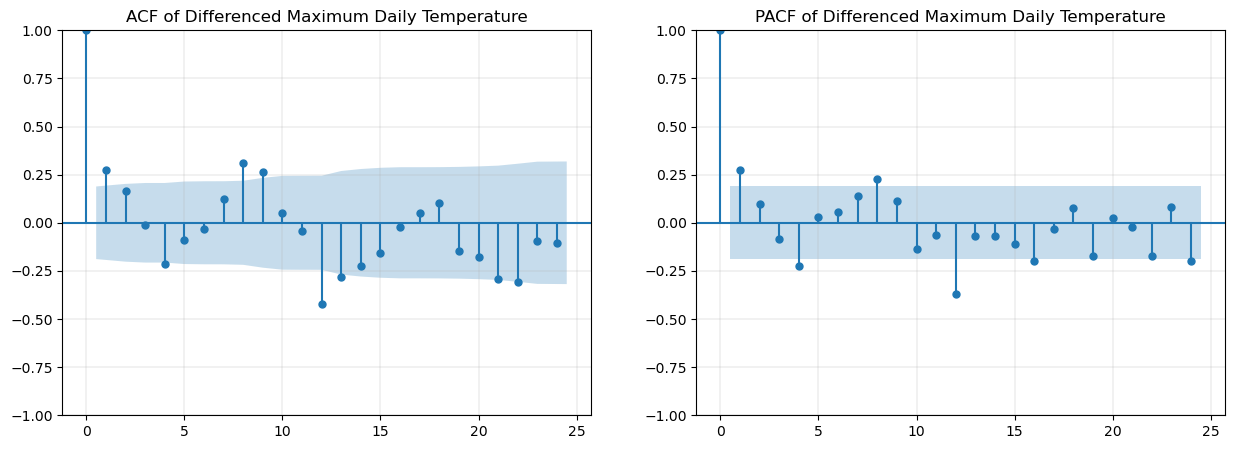

In [41]:
seasonal_diff_training = train_weather['TMAX'].diff(12).dropna()

# plot the differenced series
plt.figure(figsize=(15, 5))
plt.plot(seasonal_diff_training)
plt.title('Differenced Maximum Daily Temperature with Seasonal Differencing')
plt.grid(linewidth=0.25)
plt.show()

# plot ACF and PACF for differenced series to determine AR and MA orders
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(seasonal_diff_training, lags=24, ax=ax1)
ax1.set_title('ACF of Differenced Maximum Daily Temperature')
ax1.grid(linewidth=0.25)

plot_pacf(seasonal_diff_training, lags=24, ax=ax2)
ax2.set_title('PACF of Differenced Maximum Daily Temperature')
ax2.grid(linewidth=0.25)

plt.show()

The differenced maximum daily temperature with seasonal differencing plot looks stationary, suggesting that taking one seasonal difference is enough to put it in a workable state where it is possible to implement the SARIMAX model. Looking at multiples of 12 in the ACF and PACF plots, there is only a significant lag at lag 12 and none further on, which suggests a seasonal ARIMA(1,0,1) model. For the non-seasonal component, both lags from the ACF and PACF plots tail off, so the results are inconclusive. 

In [42]:
order = (0,0,0)
seasonal_order = (1,1,1,12)

# create a SARIMA model
model_test = SARIMAX(train_weather['TMAX'], order = order, seasonal_order = seasonal_order)

# fit the model
results_test = model_test.fit() 

aic_value = results_test.aic

print("AIC:", aic_value)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24942D+00    |proj g|=  1.21744D-01

At iterate    5    f=  2.18892D+00    |proj g|=  7.28397D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     10      1     0     0   1.126D-05   2.189D+00
  F =   2.1887961045505389     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
AIC: 531.3110650921293


 This problem is unconstrained.


In [43]:
results = pm.auto_arima(train_weather['TMAX'],
                       seasonal = True,
                       m = 12,
                       D = 1,
                       start_P = 1,
                       start_Q = 1,
                       end_P = 5,
                       end_Q = 5)

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -257.883
Date:                            Tue, 19 Dec 2023   AIC                            523.766
Time:                                    22:38:25   BIC                            534.494
Sample:                                01-31-2003   HQIC                           528.116
                                     - 12-31-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1974      0.092     -2.150      0.032      -0.377      -0.017
ma.L1          0.1956      0.093   

Comparing the AIC values of my test model and the automatically generated model by pmdarima, the model recommended by pmdarima is the most ideal since it has the smallest AIC value.  

In [44]:
# create a SARIMA model
model = SARIMAX(train_weather['TMAX'], order = (0,0,1), seasonal_order = (0,1,1,12))

# fit the model
results = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20373D+00    |proj g|=  8.11053D-02

At iterate    5    f=  2.16470D+00    |proj g|=  3.03314D-03

At iterate   10    f=  2.16461D+00    |proj g|=  1.56097D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   1.561D-06   2.165D+00
  F =   2.1646090692068238     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [45]:
# print the results summary
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               TMAX   No. Observations:                  120
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -259.753
Date:                            Tue, 19 Dec 2023   AIC                            525.506
Time:                                    22:38:29   BIC                            533.553
Sample:                                01-31-2003   HQIC                           528.769
                                     - 12-31-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2108      0.093      2.260      0.024       0.028       0.394
ma.S.L12      -0.7841      0.106   

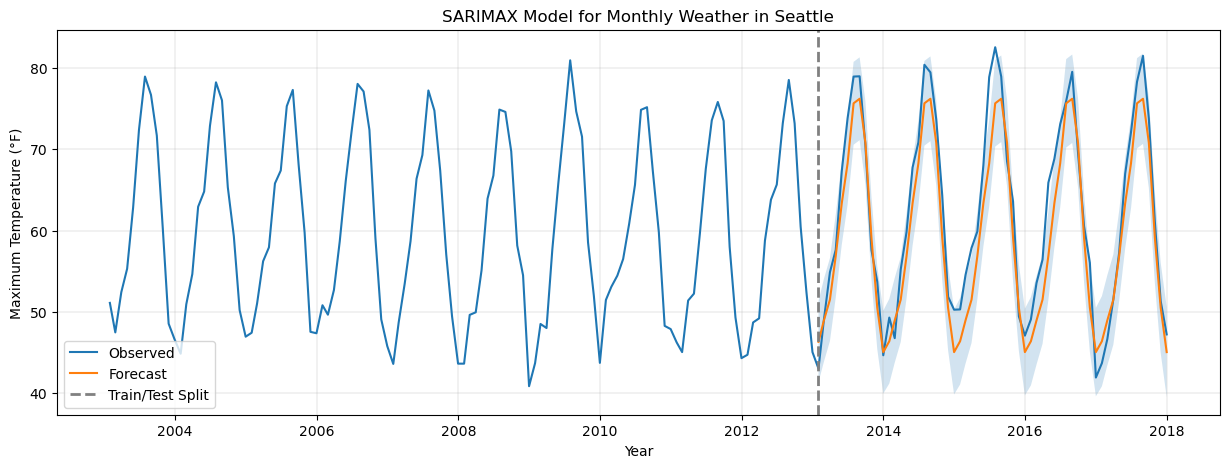

In [46]:
forecast_object = results.get_forecast(steps = 60)

conf_int = forecast_object.conf_int()

# print confidence interval

mean = forecast_object.predicted_mean

# extract the forecast dates
dates = mean.index

# plot past CO2 levels
plt.figure(figsize=(15, 5))
plt.plot(seaweather_15yr.index, seaweather_15yr['TMAX'], label='Observed')

plt.plot(dates, mean, label='Forecast')
plt.fill_between(dates, conf_int['lower TMAX'], conf_int['upper TMAX'], alpha=0.2)

# set plot attributes
plt.legend()
plt.title('SARIMAX Model for Monthly Weather in Seattle')
plt.xlabel('Year')
plt.ylabel('Maximum Temperature (°F)')
plt.grid(linewidth = 0.25)

plt.axvline(x=seaweather_15yr.index[120], color='gray', linestyle='--', linewidth=2, label='Train/Test Split')
plt.legend()

This SARIMAX model is created using a train/test split where the model was trained on ten years of maximum daily temperature data (2003-2012) and assessed based on prediction accuracy with five years of test data (2013-2017).

The attributes of this forecast are very similar to the one fit for exponential smoothing with seasonality, as it captures the yearly seasonal pattern perfectly, but misses the high and low points. The forecast is relatively constant, as the peaks and highs occur at the same time every year.  

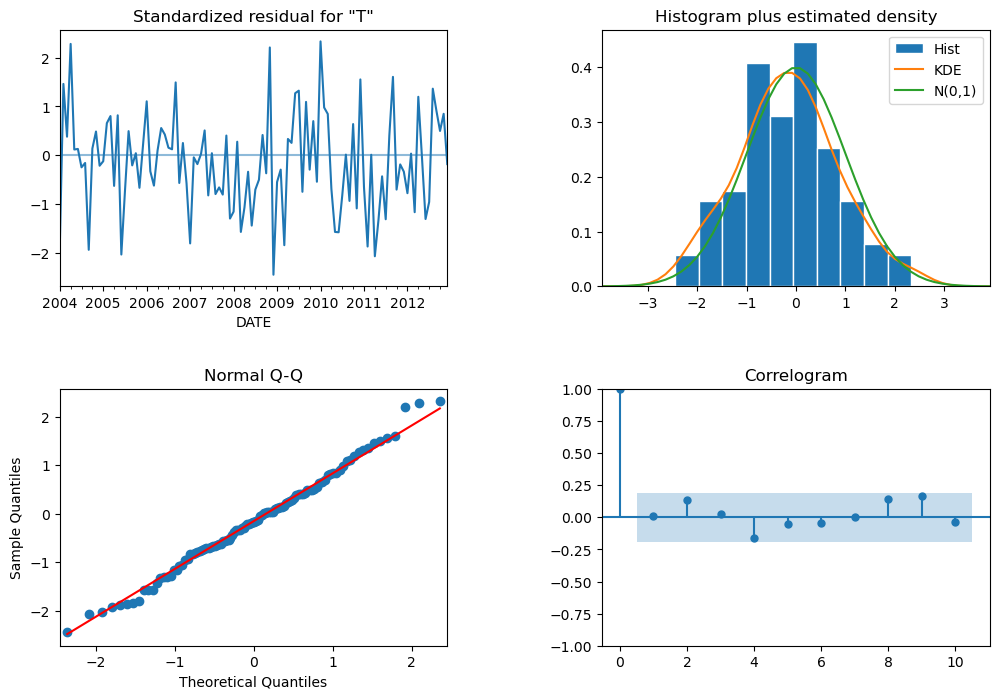

In [47]:
# plot diagnostics
results.plot_diagnostics(figsize=(12, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

The residuals plot has the uncorrelated Gaussian noise centered at zero, which is the ideal result. The distribution of residuals is slightly skewed left, but it is not statistically significant enough to be considered a problem. The points fit perfectly on the Q-Q plot except for a few outliers at each end of the line. For the autocorrelation plot, there are no significant lags, which is the most ideal condition. This model meets the minimum condition that 95% of the autocorrelations for lags greater than zero should not be significant. Based on this analysis, it is fair to conclude that the SARIMAX orders that were chosen for this data are the ideal fit!

In [48]:
# actual values for the test period
actual_values = seaweather_15yr.loc['2013-01-01':, 'TMAX']

# calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, mean)
print(f'Mean Absolute Error (MAE): {mae:.2f}°F')

# calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(actual_values, mean))
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}°F')

Mean Absolute Error (MAE): 3.32°F
Root Mean Squared Error (RMSE): 3.90°F


# SARIMAX Forecast Into The Future

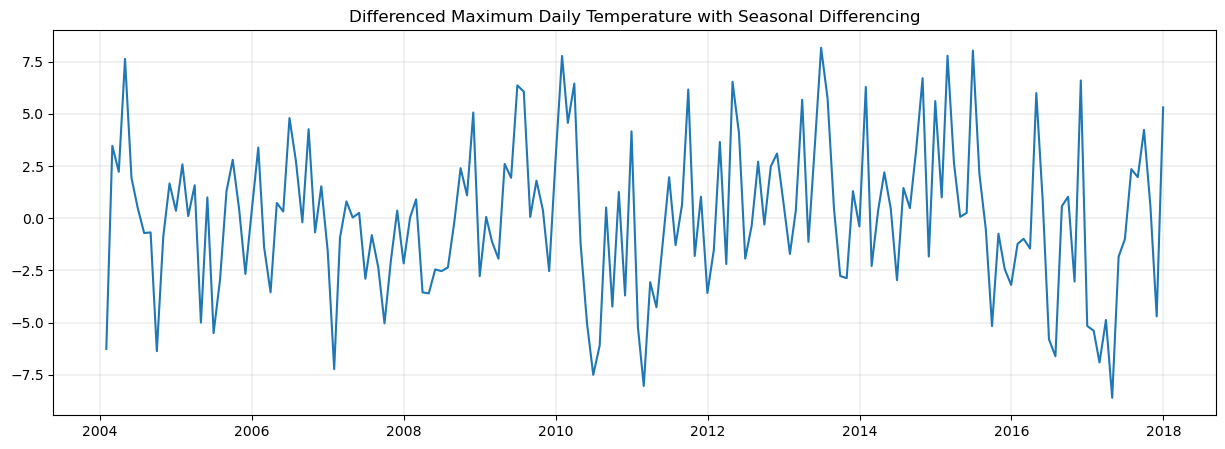

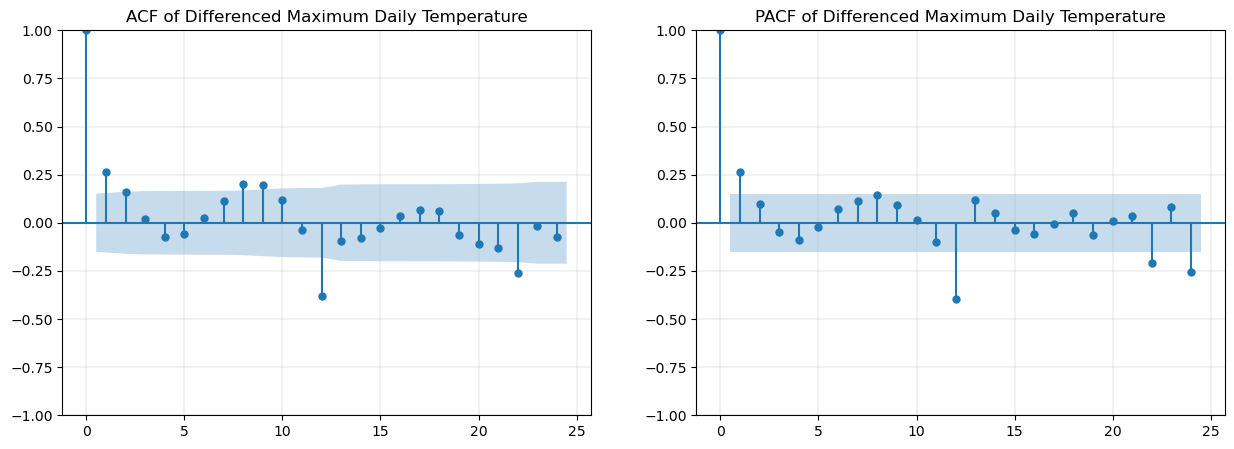

In [49]:
all_data = seaweather_15yr.loc[('2003-01-01' <= seaweather_15yr.index) & (seaweather_15yr.index <= '2017-12-31')]

seasonal_diff_training_all = all_data['TMAX'].diff(12).dropna()

# plot the differenced series
plt.figure(figsize=(15, 5))
plt.plot(seasonal_diff_training_all)
plt.title('Differenced Maximum Daily Temperature with Seasonal Differencing')
plt.grid(linewidth=0.25)
plt.show()

# plot ACF and PACF for differenced series to determine AR and MA orders
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(seasonal_diff_training_all, lags=24, ax=ax1)
ax1.set_title('ACF of Differenced Maximum Daily Temperature')
ax1.grid(linewidth=0.25)

plot_pacf(seasonal_diff_training_all, lags=24, ax=ax2)
ax2.set_title('PACF of Differenced Maximum Daily Temperature')
ax2.grid(linewidth=0.25)

plt.show()

The differenced maximum daily temperature with seasonal differencing plot looks stationary, suggesting that taking one seasonal difference is enough to put it in a workable state where it is possible to implement the SARIMAX model. Looking at multiples of 12 in the ACF and PACF plots, there is only a significant lag at lag 12 for the ACF plot and lags at 12 and 24 for the PACF plot, which suggests a seasonal ARIMA(1,0,2) model. For the non-seasonal component, both lags from the ACF and PACF plots tail off, so the results are inconclusive. 

In [50]:
order_all = (0,0,0)
seasonal_order_all = (1,1,2,12)

# create a SARIMA model
model_test_all = SARIMAX(all_data['TMAX'], order = order_all, seasonal_order = seasonal_order_all)

# fit the model
results_test_all = model_test_all.fit() 

aic_value = results_test_all.aic

print("AIC:", aic_value)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.38847D+00    |proj g|=  1.33802D-01

At iterate    5    f=  2.35366D+00    |proj g|=  3.32220D-03


 This problem is unconstrained.



At iterate   10    f=  2.35102D+00    |proj g|=  1.03381D-02

At iterate   15    f=  2.34869D+00    |proj g|=  3.81992D-03

At iterate   20    f=  2.34795D+00    |proj g|=  1.93906D-03

At iterate   25    f=  2.34778D+00    |proj g|=  5.49811D-04

At iterate   30    f=  2.34776D+00    |proj g|=  1.95735D-04

At iterate   35    f=  2.34776D+00    |proj g|=  6.18827D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     40      1     0     0   7.362D-06   2.348D+00
  F =   2.3477565691438276     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
AIC: 853.192364891778


In [51]:
results = pm.auto_arima(all_data['TMAX'],
                       seasonal = True,
                       m = 12,
                       D = 1,
                       start_P = 1,
                       start_Q = 1,
                       end_P = 5,
                       end_Q = 5)

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -418.214
Date:                            Tue, 19 Dec 2023   AIC                            846.428
Time:                                    22:39:36   BIC                            862.048
Sample:                                01-31-2003   HQIC                           852.768
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2941      0.082      3.568      0.000       0.133       0.456
ar.L2          0.1481      0.081   

Comparing the AIC values of the test model and the automatically generated model by pmdarima, the model recommended by pmdarima is the most ideal since it has the smallest AIC value.  

In [52]:
# create a SARIMA model
model_all = SARIMAX(all_data['TMAX'], order = (2,0,0), seasonal_order = (2,1,0,12))

results_all = model_all.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35186D+00    |proj g|=  7.86735D-02

At iterate    5    f=  2.32341D+00    |proj g|=  1.11591D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   1.134D-05   2.323D+00
  F =   2.3234122171230656     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


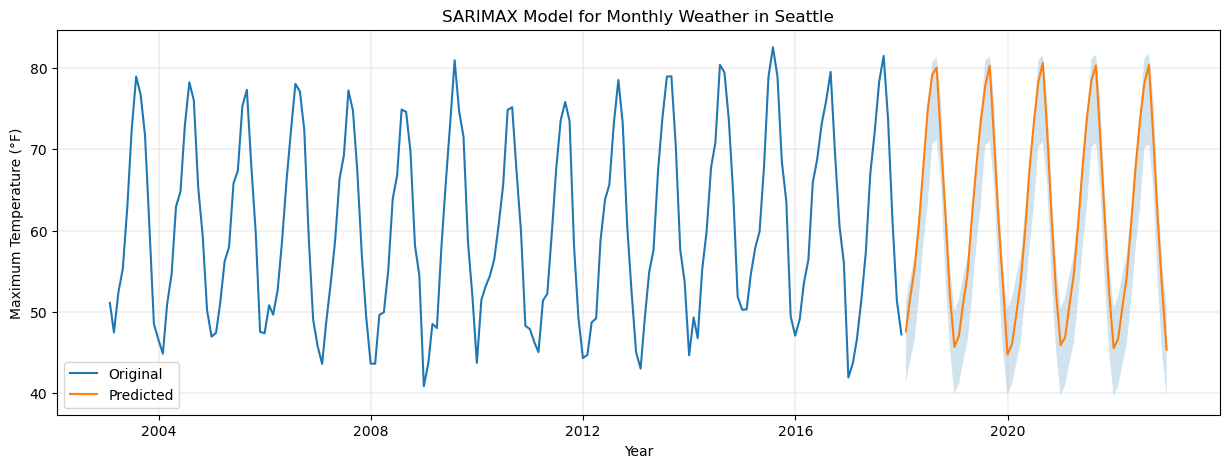

In [53]:
forecast_object_all = results_all.get_forecast(steps = 60)

conf_int_all = forecast_object_all.conf_int()

# print confidence interval

mean_all = forecast_object_all.predicted_mean

# extract the forecast dates
dates_all = mean_all.index

# plot past CO2 levels
plt.figure(figsize=(15, 5))
plt.plot(seaweather_15yr.index, seaweather_15yr['TMAX'], label='Original')

plt.plot(dates_all, mean_all, label='Predicted')
plt.fill_between(dates_all, conf_int['lower TMAX'], conf_int['upper TMAX'], alpha=0.2)

# set plot attributes
plt.legend()
plt.title('SARIMAX Model for Monthly Weather in Seattle')
plt.xlabel('Year')
plt.ylabel('Maximum Temperature (°F)')
plt.grid(linewidth = 0.25)

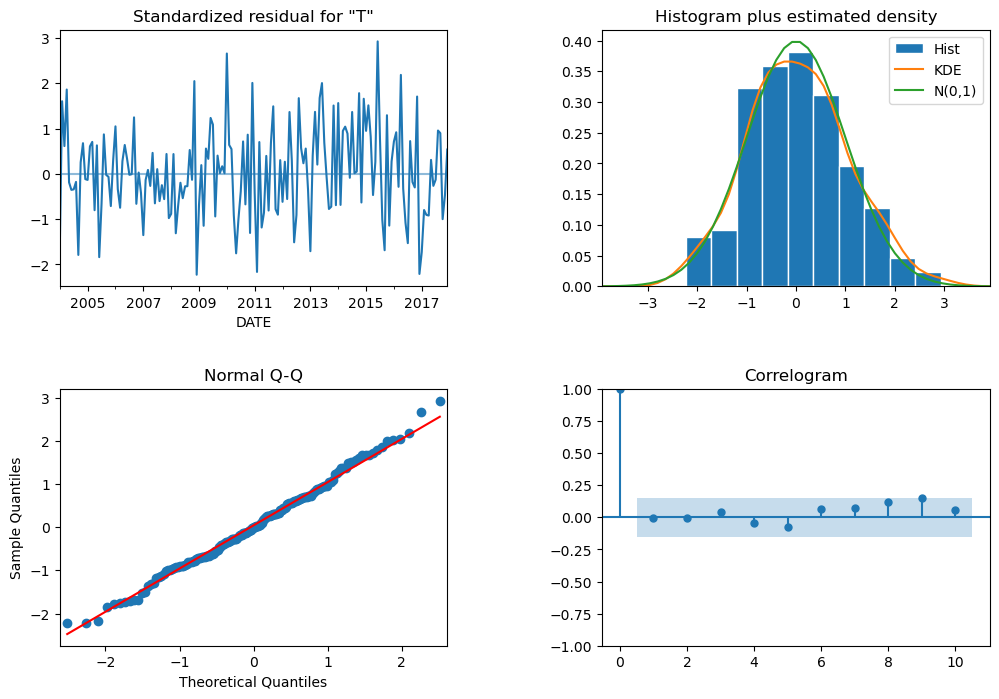

In [54]:
# plot diagnostics
results_all.plot_diagnostics(figsize=(12, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

The residuals plot has the uncorrelated Gaussian noise centered at zero, which is ideal. The distribution of residuals is slightly skewed left, but it is not statistically significant enough to be considered a problem. The points fit perfectly on the Q-Q plot except for a few outliers at each end of the line. For the autocorrelation plot, there are no significant lags, which is the most ideal condition. It meets the minimum condition that 95% of the autocorrelations for lags greater than zero should not be significant. Based on this analysis, it is fair to conclude that the SARIMAX orders that were chosen for this data are the ideal fit!